In [1]:
import os
import torch
import data
import utils
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
import config as cfg
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from xpbd_softbody_layer import XPBDStep
import pyvista as pv
import matplotlib.pyplot as plt
from xpbd_softbody import XPBDSoftbody

In [2]:
mesh, softbody = data.get_xpbd_grape()

torch.Size([600, 3])
torch.Size([1200, 3])


In [3]:
control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
                               [0.000197, 0.004594, 0.004361],
                               [0.000197, -0.00004, 0.006602],
                               [0.000208, -0.00404, 0.008502]])
# control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
#                                [0.000186, 0.008863, 0.002481],
#                                [0.000208, 0.00664, 0.003521],
#                                [0.000197, 0.004594, 0.004361],
#                                [0.000208, 0.002349, 0.005903],
#                                [0.000197, -0.00004, 0.006602],
#                                [0.000208, -0.00204, 0.007502],
#                                [0.000208, -0.00404, 0.008502]])

In [4]:
control_point = 31

In [5]:
target_point = 26

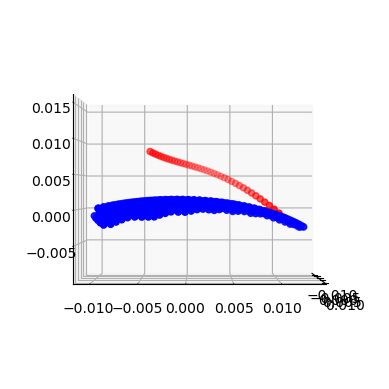

In [6]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser
f = interp1d(x, control_trajectory, axis=0, kind='cubic')
control_trajectory = f(xnew)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(control_trajectory[:, 0], control_trajectory[:, 1], control_trajectory[:, 2], c='r', marker='o')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)
plt.show()

In [7]:
control_trajectory = torch.from_numpy(control_trajectory).to(cfg.device)
softbody.fix_point(0, control_point)

cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

In [8]:
def get_energy_boundary(softbody: XPBDSoftbody,
                         V_predict: torch.Tensor,
                         V_boundary_stiffness: torch.Tensor,
                         mask: set = None) -> torch.Tensor:
    
    V_boundary_stiffness_threshold = V_boundary_stiffness.clone()
    # V_boundary_stiffness_threshold[V_boundary_stiffness_threshold < 1e-3] = 0
    V_boundary_stiffness_threshold = V_boundary_stiffness_threshold * torch.sigmoid(V_boundary_stiffness_threshold - 1e-3)


    dist_C, dist_C_stiffness = __get_spring_boundary_constraints(softbody,
                                                      V_predict,
                                                      V_boundary_stiffness_threshold,
                                                      mask)
    # energy is C^2 * stiffness / 2
    boundary_energy = torch.square(dist_C) * dist_C_stiffness / 2
    return boundary_energy

def __get_spring_boundary_constraints(softbody, V_predict, V_boundary_stiffness, mask=None):
    C = []
    C_stiffness = []
    # collect all distance constraints
    for C_dist, C_init_d in zip(softbody.C_boundary_list, softbody.C_init_boundary_d_list):
        if mask == None or (C_dist[:, 0] in mask and C_dist[:, 1] in mask):
            # position difference vectors
            N = V_predict[C_dist[:, 0]] - V_predict[C_dist[:, 1]]
            # distance
            D = torch.norm(N, p=2, dim=1, keepdim=True)
            # constarint values
            C.append(D - C_init_d)
            # average stiffness
            C_stiffness.append(V_boundary_stiffness[C_dist[:, 0]])
    return torch.cat(C), torch.cat(C_stiffness)

In [9]:
pv.set_plot_theme('document')
pl = pv.Plotter()

# skin being peeled
pl.add_mesh(mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')

# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')

Actor (0x7f525ae7e080)
  Center:                     (-9.851530194282532e-06, 0.0014494163915514946, -0.0009795548299327494)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    -6.636E-03, 6.616E-03
  Y Bounds                    -1.040E-02, 1.330E-02
  Z Bounds                    -3.189E-03, 1.230E-03
  User matrix:                Set
  Has mapper:                 True

Property (0x7f525ae7e440)
  Ambient:                     0.0
  Ambient color:               Color(hex='#c0ab5eff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(hex='#c0ab5eff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(hex='#c0ab5eff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity:                1.0
 

In [10]:
with torch.no_grad():
    for t in range(1, control_trajectory.shape[0]):
        softbody.V[control_point] = control_trajectory[t]

        step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=None,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=cfg.use_shape_matching,
                        use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()

        energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
        
        V_boundary_stiffness[:cfg.n_surf] = V_boundary_stiffness[:cfg.n_surf] * torch.sigmoid(1e9 * (1e-8 - energy))

        mesh.points = softbody.V.cpu().numpy()
        # pl.show(interactive_update=True)

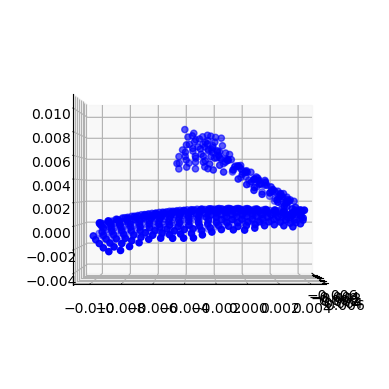

In [11]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)
plt.show()

In [12]:
target_pos = softbody.V[control_point].clone()

In [13]:
target_pos

tensor([ 0.0002, -0.0040,  0.0085], device='cuda:0')

In [80]:
mesh, softbody = data.get_xpbd_grape()
softbody.fix_point(0, control_point)

torch.Size([600, 3])
torch.Size([1200, 3])


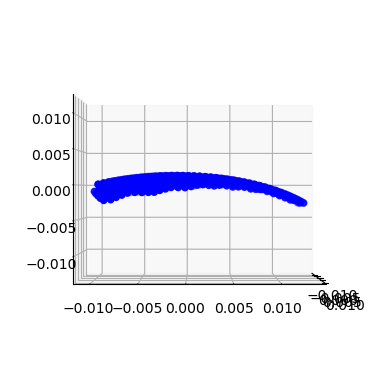

In [81]:
# interpolate trajectory
mesh.points = softbody.V.detach().cpu().numpy()
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
# ax.scatter(mesh.points[control_list, 0], mesh.points[control_list, 1], mesh.points[control_list, 2], c='r', marker='o')
# ax.scatter(mesh.points[target_list, 0], mesh.points[target_list, 1], mesh.points[target_list, 2], c='y', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)

In [82]:
# Hardcoded control trajectory
cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

In [83]:
def loss_fn(target, predict):
    return torch.norm(target - predict)

In [84]:
u = torch.linspace(0, 1, 4).to(cfg.device)
us = torch.linspace(0, 1, 20).to(cfg.device)
start_point = np.array([[0.000224, 0.010794, -0.001233]])
start_point = torch.from_numpy(start_point).to(cfg.device)
spline_control = np.array([ [0.000197, 0.004594, 0.004361],
                            [0.000197, -0.00004, 0.006602],
                            [0.000208, -0.00404, 0.008502]])
spline_control = torch.from_numpy(spline_control).to(cfg.device)
spline_control.requires_grad_(True)

tensor([[ 1.9700e-04,  4.5940e-03,  4.3610e-03],
        [ 1.9700e-04, -4.0000e-05,  6.6020e-03],
        [ 2.0800e-04, -4.0400e-03,  8.5020e-03]], device='cuda:0',
       dtype=torch.float64, requires_grad=True)

In [85]:
torch.autograd.set_detect_anomaly(True)

In [86]:
torch.vstack((start_point, spline_control))

tensor([[ 2.2400e-04,  1.0794e-02, -1.2330e-03],
        [ 1.9700e-04,  4.5940e-03,  4.3610e-03],
        [ 1.9700e-04, -4.0000e-05,  6.6020e-03],
        [ 2.0800e-04, -4.0400e-03,  8.5020e-03]], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)

In [87]:
optimizer = torch.optim.Adam([spline_control], lr=0.01)

In [88]:
def h_poly_helper(tt):
  A = torch.tensor([
      [1, 0, -3, 2],
      [0, 1, -2, 1],
      [0, 0, 3, -2],
      [0, 0, -1, 1]
      ], dtype=tt[-1].dtype)
  return [
    sum( A[i, j]*tt[j] for j in range(4) )
    for i in range(4) ]

def h_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = 1
  for i in range(1, 4):
    tt[i] = tt[i-1]*t
  return h_poly_helper(tt)

def H_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = t
  for i in range(1, 4):
    tt[i] = tt[i-1]*t*i/(i+1)
  return h_poly_helper(tt)

def interp_func(x, y):
  "Returns integral of interpolating function"
  if len(y)>1:
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  def f(xs):
    if len(y)==1: # in the case of 1 point, treat as constant function
      return y[0] + torch.zeros_like(xs)
    I = torch.searchsorted(x[1:], xs)
    dx = (x[I+1]-x[I])
    hh = h_poly((xs-x[I])/dx)
    return hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
  return f

def interp(x, y, xs):
  return interp_func(x,y)(xs)

def integ_func(x, y):
  "Returns interpolating function"
  if len(y)>1:
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
    Y = torch.zeros_like(y)
    Y[1:] = (x[1:]-x[:-1])*(
        (y[:-1]+y[1:])/2 + (m[:-1] - m[1:])*(x[1:]-x[:-1])/12
        )
    Y = Y.cumsum(0)
  def f(xs):
    if len(y)==1:
      return y[0]*(xs - x[0])
    I = torch.searchsorted(x[1:], xs)
    dx = (x[I+1]-x[I])
    hh = H_poly((xs-x[I])/dx)
    return Y[I] + dx*(
        hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
        )
  return f

def integ(x, y, xs):
  return integ_func(x,y)(xs)

In [89]:
control = []
loss_list = []
pre_loss = 100
for t in range(1):
    x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
    y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
    z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
    spline_x = interp(u, x_con, us)
    spline_y = interp(u, y_con, us)
    spline_z = interp(u, z_con, us)
    spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
    
    for i in range(spline_trajectory.shape[0]):
        softbody.V[control_point] = spline_trajectory[i]
        step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=None,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=cfg.use_shape_matching,
                        use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()
        energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
        V_boundary_stiffness[:cfg.n_surf] = V_boundary_stiffness[:cfg.n_surf] * torch.sigmoid(1e9 * (1e-8 - energy))

    loss = loss_fn(target_pos, V_ref[target_point])
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    if abs(loss.detach() - pre_loss) < 0.001:
        loss_list.append(loss.detach())
        break
    pre_loss = loss.detach()
    loss_list.append(pre_loss)


    # mesh.points = softbody.V.cpu().numpy()

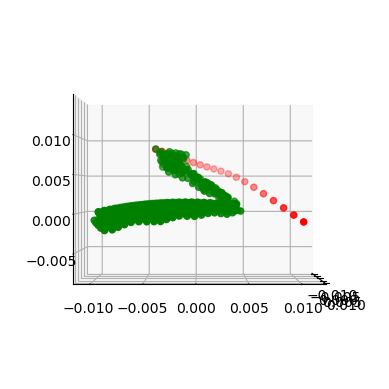

In [97]:
# interpolate trajectory
control = np.array(control)
mesh.points = softbody.V.detach().cpu().numpy()
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='g', marker='o')
ax.scatter(spline_trajectory[:, 0].cpu().detach(), spline_trajectory[:, 1].cpu().detach(), spline_trajectory[:, 2].cpu().detach(), c='r', marker='o')
# ax.scatter(mesh.points[target_list, 0], mesh.points[target_list, 1], mesh.points[target_list, 2], c='b', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)
plt.show()

Text(0, 0.5, 'loss')

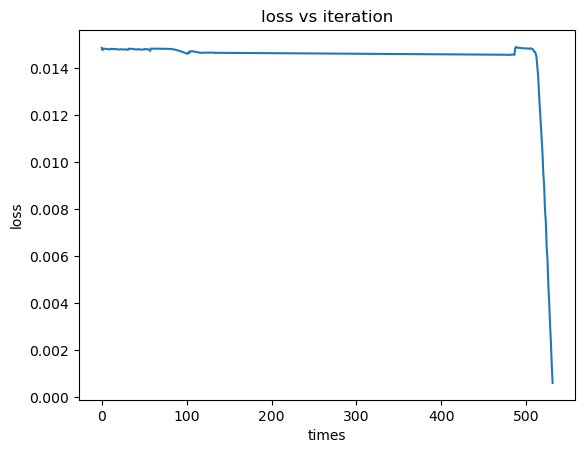

In [ ]:
plt.plot(loss_list)
plt.title('loss vs iteration')
plt.xlabel('times')
plt.ylabel('loss')

In [ ]:
softbody.V[target_point]

tensor([ 0.0003, -0.0044,  0.0088], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
target_pos

tensor([ 0.0002, -0.0040,  0.0085], device='cuda:0')